In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sb
import matplotlib.pyplot as plt
import ssl
import requests
from scipy.stats import linregress
from sklearn.model_selection import LeaveOneOut

In [2]:
attributes = pd.read_csv('attributes.txt')
data = pd.read_csv('communities.data', names=attributes['attributes'])
data.drop(columns=['state', 'county', 'community', 'communityname', 'fold'], inplace=True)
data = data.sample(frac=1, random_state=34).reset_index(drop=True)

In [3]:
data.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.40,0.56,0.09,0.64,0.06,0.94,0.48,0.52,0.32,0.31,...,0.39,0.16,0.10,0.21,0.07,0.78,1,0.64,0.09,0.33
1,0.05,0.41,0.14,0.76,0.32,0.09,0.50,0.72,0.59,0.42,...,0.06,0.16,0.44,?,?,?,?,0.00,?,0.26
2,0.01,0.41,0.03,0.86,0.43,0.09,0.26,0.38,0.23,0.58,...,0.00,0.58,0.49,?,?,?,?,0.00,?,0.06
3,0.01,1.00,0.31,0.68,0.14,0.09,1.00,1.00,1.00,0.06,...,0.03,0.14,0.00,?,?,?,?,0.00,?,0.24
4,0.03,0.19,0.25,0.75,0.10,0.22,0.22,0.50,0.29,0.41,...,0.02,0.35,0.16,?,?,?,?,0.00,?,0.66


In [4]:
#We check and see that all rows have some missing data
count_rows_with_question_mark = (data == '?').any(axis=1).sum()
count_rows_with_question_mark

np.int64(1675)

In [5]:
t = 30

#removed attributes
'''
LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 
'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 
'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 
'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 
'LemasGangUnitDeploy', 'PolicBudgPerPop'
'''
#we remove columns with a high value of unknown values, we set the limit at 30%, the remainder we fill as NA
question_mark_percentage = (data.isin(['?']).sum() / len(data)) * 100
to_remove = question_mark_percentage[question_mark_percentage > t]
data.drop(columns=to_remove.index.to_list(), inplace=True)

data.replace('?', np.nan, inplace=True)
for i in data.columns:
    data[i] = data[i].astype(float)    
    data[i] = data[i].fillna(data[i].mean())

In [6]:
X = data.drop(columns=['ViolentCrimesPerPop'])
y = data['ViolentCrimesPerPop']

In [7]:
#function that creates k folds
def split_folds(k, data, seed=42):
    data = data.sample(frac=1, random_state=seed).reset_index(drop=True)

    indexes = data.index.to_numpy()
    fold_sizes = np.array_split(indexes, k)  # Split indexes into k folds based on size
    
    split_indexes = []
    
    for i in range(k):
        test_indexes = fold_sizes[i]
        
        train_indexes = np.concatenate([fold_sizes[j] for j in range(k) if j != i])
        
        split_indexes.append((train_indexes, test_indexes))
        
    return split_indexes

#funcation that trains k models and returns a list of MAE and MSE
def train_model_fold(X,y, folds_m):
    all_results = []
    
    for i, (train_indexes, test_indexes) in enumerate(folds_m):   
        train_X, train_y = X.iloc[train_indexes], y.iloc[train_indexes]
        test_X, test_y = X.iloc[test_indexes], y.iloc[test_indexes]
    
        train_X = np.hstack([np.ones((train_X.shape[0], 1)), train_X])
        test_X = np.hstack([np.ones((test_X.shape[0], 1)), test_X])
    
        betas = np.linalg.inv(train_X.T @ train_X) @ train_X.T @ train_y
        pred_y = test_X @ betas
    
        mae = mean_absolute_error(test_y, pred_y)
        mse = mean_squared_error(test_y, pred_y)
        all_results.append((mae, mse))

    return all_results


#first we run our code for 10 folds and the for length of data folds (leave one out cross validatin)
k = 10
folds = split_folds(k, X)
results = train_model_fold(X,y, folds)

print("10 folds:")
print("min MSE: " + str(min(item[1] for item in results)))
print("max MSE: " + str(max(item[1] for item in results)))
print("avg MSE: " + str(sum(item[1] for item in results) / len(results)))

k = len(data)
folds = split_folds(k, X)
results = train_model_fold(X,y, folds)

print("\nLeave one out:")
print("min MSE: " + str(min(item[1] for item in results)))
print("max MSE: " + str(max(item[1] for item in results)))
print("avg MSE: " + str(sum(item[1] for item in results) / len(results)))

10 folds:
min MSE: 0.016461136864592454
max MSE: 0.020762883041026203
avg MSE: 0.018641841868913753

Leave one out:
min MSE: 5.736660230192266e-09
max MSE: 0.6305069950156008
avg MSE: 0.01852320616830891


In [8]:
model = LinearRegression()

# Leave-One-Out Cross-Validation SKlearn implementation we can see that we get a similair result
loo = LeaveOneOut()
mse_scores = [] 

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse_scores.append(mean_squared_error(y_test, y_pred))

average_mse = np.mean(mse_scores)
print(f"Average MSE from LOOCV: {average_mse}")


Average MSE from LOOCV: 0.01852320616831318


In [9]:
def forward_feature_selection(X_m, y_m):
    values = X_m.columns.values.tolist() #get attributes 

    used_attrs = []
    best_mae = 1
    final = []

    #get LOOCV folds
    k = len(X_m)
    folds = split_folds(k, X_m)
    
    while True:
        value_mae = {}

        mean_error = 0.0

        #We run leave one out cross validation for each attribute and add the best one to our selection 
        for value in values:    
            if value in used_attrs:
                continue 
                  
            selected_features = used_attrs + [value] 

            results = train_model_fold(X_m[selected_features],y_m, folds)

            value_mae[value]= sum(item[1] for item in results)/len(results)
        
        new_mae_attr = min(value_mae, key=value_mae.get)
        new_mae = value_mae[new_mae_attr]

        print(new_mae)
        print(new_mae_attr)
        #print((best_mae - new_mae) / best_mae)

        #we stop selecting if the model gets worse or the improvement is less than 0.5%
        if new_mae >= best_mae or (best_mae - new_mae) / best_mae < 0.005:
            break
        else:
            best_mae = new_mae
            used_attrs.append(new_mae_attr)
    return used_attrs, value_mae

used_attrs, value_mae = forward_feature_selection(X, y)

#print('Current attributes:')
print(len(used_attrs))

0.024733147208333122
PctKids2Par
0.02179872907035753
racePctWhite
0.020370772377879206
HousVacant
0.020040647290803876
pctUrban
0.019787569267536897
PctWorkMom
0.019591002953844396
NumStreet
0.019410767199928042
MalePctDivorce
0.019147378453673033
PctIlleg
0.019000473960988768
numbUrban
0.01889402083038146
PctPersDenseHous
0.018744337233642515
racepctblack
0.018660848787723495
agePct12t29
11


In [10]:
print(used_attrs)

['PctKids2Par', 'racePctWhite', 'HousVacant', 'pctUrban', 'PctWorkMom', 'NumStreet', 'MalePctDivorce', 'PctIlleg', 'numbUrban', 'PctPersDenseHous', 'racepctblack']


In [11]:
#We test our selected attributes on a new train test split
split_ratio = 0.7
split_index = int(len(data) * split_ratio) 
train_subset = X[used_attrs].iloc[:split_index].values
test_subset = X[used_attrs].iloc[split_index:].values

train_y = y.iloc[:split_index]
test_y = y.iloc[split_index:]

train_subset = np.hstack([np.ones((train_subset.shape[0], 1)), train_subset])
test_subset = np.hstack([np.ones((test_subset.shape[0], 1)), test_subset])

betas = np.linalg.inv(train_subset.T @ train_subset) @ train_subset.T @ train_y
pred_y = test_subset @ betas

mse = mean_squared_error(test_y, pred_y)
mae = mean_absolute_error(test_y, pred_y)
r2 = r2_score(test_y, pred_y)

print("Results\nMSE = {}\nMAE = {}\nR^2 = {}".format(mse, mae, r2))

Results
MSE = 0.01825602815051885
MAE = 0.0943110866030882
R^2 = 0.6712085545335024


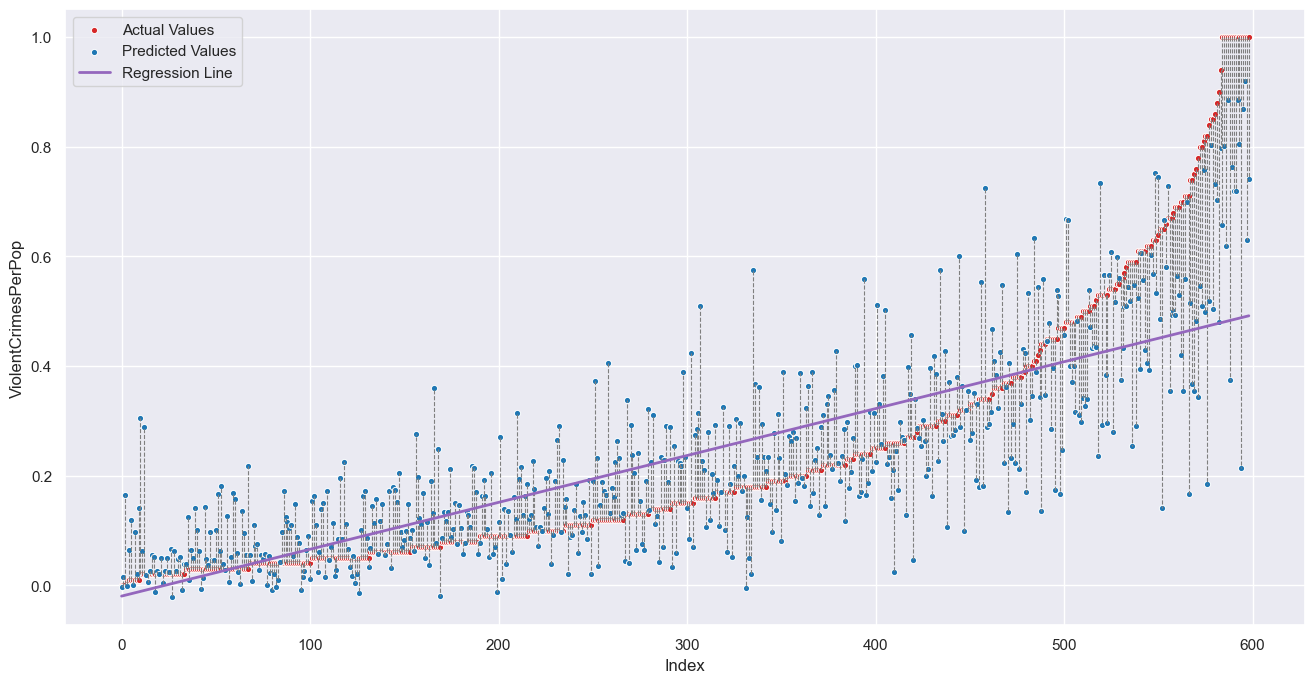

In [12]:
y_test_np = np.array(test_y)
pred_y_np = np.array(pred_y)

sorted_indices = np.argsort(y_test_np)
y_test_np = y_test_np[sorted_indices]
pred_y_np = pred_y_np[sorted_indices]

index = np.arange(len(y_test_np))

sb.set(style="darkgrid")
colors = sb.color_palette(["#1f77b4", "#d62728", "#7f7f7f", "#9467bd"])

plt.figure(figsize=(16, 8))

sb.scatterplot(x=index, y=y_test_np, color=colors[1], s=20, label="Actual Values", edgecolor="w", linewidth=0.7)
sb.scatterplot(x=index, y=pred_y_np, color=colors[0], s=20, label="Predicted Values", edgecolor="w", linewidth=0.7)

for i in range(len(y_test_np)):
    plt.plot([index[i], index[i]], [y_test_np[i], pred_y_np[i]], linestyle="--", color=colors[2], linewidth=0.8)

slope, intercept, _, _, _ = linregress(index, pred_y_np)
regression_line = slope * index + intercept
sb.lineplot(x=index, y=regression_line, color=colors[3], linewidth=2, label="Regression Line")

plt.xlabel("Index")
plt.ylabel("ViolentCrimesPerPop")
plt.legend()
plt.show()

In [13]:
def do_bootstrap(train_X, train_y, test_X, test_y, n_bootstraps=1000, random_state=42):
    np.random.seed(random_state)
    n_samples = len(train_y)
    all_bootstrap_results = []

    #we train 1000 models and test them using our previously defined test set
    for _ in range(n_bootstraps):

        #we select 1000 random values from our train set to make a new train set
        bootstrap_indices = np.random.choice(range(n_samples), size=n_samples, replace=True)

        bootstrap_X, bootstrap_y = train_X[bootstrap_indices], train_y[bootstrap_indices]

        betas = np.linalg.inv(bootstrap_X.T @ bootstrap_X) @ bootstrap_X.T @ bootstrap_y

        pred_y = test_X @ betas
        mae = mean_absolute_error(test_y, pred_y)
        mse = mean_squared_error(test_y, pred_y)
        r2 = r2_score(test_y, pred_y)

        # Append the results
        all_bootstrap_results.append((mae, mse, r2))

    return all_bootstrap_results

all_bootstrap_results_d = do_bootstrap(train_subset, train_y, test_subset, test_y)

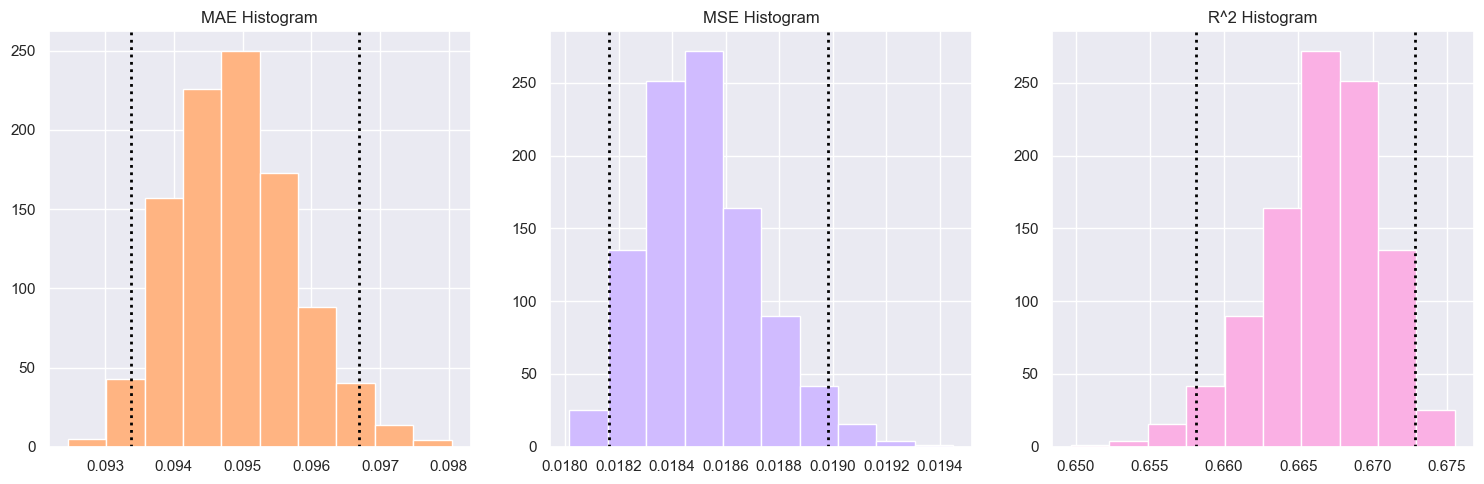

In [14]:
bootstrap_mae_results = [result[0] for result in all_bootstrap_results_d]
bootstrap_mse_results = [result[1] for result in all_bootstrap_results_d]
bootstrap_r2_results = [result[2] for result in all_bootstrap_results_d]

percentiles = [2.5, 97.5]

colors = sb.color_palette("pastel")

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(bootstrap_mae_results, color=colors[1])
lower_bound, upper_bound = np.percentile(bootstrap_mae_results, percentiles)
plt.axvline(lower_bound, color='black', linestyle='dotted', linewidth=2)
plt.axvline(upper_bound, color='black', linestyle='dotted', linewidth=2)
plt.title('MAE Histogram')

plt.subplot(1, 3, 2)
plt.hist(bootstrap_mse_results, color=colors[4])
lower_bound, upper_bound = np.percentile(bootstrap_mse_results, percentiles)
plt.axvline(lower_bound, color='black', linestyle='dotted', linewidth=2)
plt.axvline(upper_bound, color='black', linestyle='dotted', linewidth=2)
plt.title('MSE Histogram')

plt.subplot(1, 3, 3)
plt.hist(bootstrap_r2_results, color=colors[6])
lower_bound, upper_bound = np.percentile(bootstrap_r2_results, percentiles)
plt.axvline(lower_bound, color='black', linestyle='dotted', linewidth=2)
plt.axvline(upper_bound, color='black', linestyle='dotted', linewidth=2)
plt.title('R^2 Histogram')

plt.tight_layout()
plt.show()